# Exemplos de optimização de rota

## Variáveis do problema
- 5 Técnicos para atender uma região
- 14 chamados para serem atendidos
- As localizações do chamado tenho informação de CEP
- Cada chamado tem um SLA de atendimento que em um determinada janela de tempo preciso iniciar o atendimento

## Dados do problema

In [1]:
import pandas as pd

chamado = [str(i).rjust(2, '0') for i in range(1, 15)]
cep = ['22261003', '22040010', '22010030', '22231200', '20511270', '20510-110', '20560010', 
       '20715040', '20715002', '20720011', '20710010', '20061001', '20080002', '22250906']

chamados = pd.DataFrame({'chamado': chamado, 'cep': cep})
chamados.head()

,chamado,cep
0,01,22261003
1,02,22040010
2,03,22010030
3,04,22231200
4,05,20511270


## Geolocalização dos chamados

Na optimização iremos precisar calcular as distâncias entre todos os chamados para calcular uma **matriz de custo**

In [6]:
import requests
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="th1460")

def cep2coo(cep):
    response = requests.get(f'https://viacep.com.br/ws/{cep}/json/')
    results = response.json()
    try:
        query = f"{results['logradouro']}, {results['localidade']} {results['uf']}"
        data = geolocator.geocode(query)
        return data.point.longitude, data.point.latitude
    except:
        return ()

chamados['coo'] = chamados['cep'].apply(cep2coo)

### Persistindo os dados

In [7]:
import duckdb
import os

if os.path.exists('data/chamados.duckdb'):
    print('DB chamados existe')
else:
    con = duckdb.connect('data/chamados.duckdb')
    con.from_df(chamados)
    con.close()
    print('DB chamados criado')

DB chamados existe


In [8]:
con = duckdb.connect('data/chamados.duckdb')
chamados = con.sql('SELECT * FROM chamados;').fetchdf()
con.close()

chamados.head()

,chamado,cep,coo
0,01,22261003,"[-43.1983622, -22.9565513]"
1,02,22040010,"[-43.1828045, -22.9681485]"
2,03,22010030,"[-43.1667647, -22.9622599]"
3,04,22231200,"[-44.1164415, -22.5255711]"
4,05,20511270,"[-43.2396635, -22.9318121]"


### Definir *bouding box* da região

In [62]:
import osmnx as ox

lng = list(zip(*chamados.coo))[0]
lat = list(zip(*chamados.coo))[1]
place = [min(lat) + .5, max(lat) - .5, min(lng) - .1, max(lng) + .1]
place

[-22.4681485, -23.0255711, -44.2164415, -43.0667647]

### Contruir grafo com a região

In [64]:
graph = ox.graph_from_bbox(*place, simplify=True, network_type='drive')
nodes, streets = ox.graph_to_gdfs(graph)

#### Nodes

In [65]:
nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
25038483,-22.980949,-43.206859,3,NaN,NaN,POINT (-43.20686 -22.98095)
25038484,-22.981045,-43.204756,5,NaN,NaN,POINT (-43.20476 -22.98105)
25038485,-22.981160,-43.202639,4,NaN,NaN,POINT (-43.20264 -22.98116)
25038487,-22.981267,-43.200507,4,NaN,NaN,POINT (-43.20051 -22.98127)
25038488,-22.981470,-43.206925,4,NaN,NaN,POINT (-43.20693 -22.98147)


#### Vértices

In [66]:
streets.head()

osmid  oneway lanes                    name  \
u        v         key                                                  
25038483 25038488  0    4217297    True     2      Rua Maria Quitéria   
         528897321 0    4217299    True     2   Rua Alberto de Campos   
25038484 25038505  0    4217293    True     2      Rua Joana Angélica   
         25038485  0    4217299    True     2   Rua Alberto de Campos   
25038485 25038502  0    4217292    True     2  Rua Vinícius de Moraes   

                            highway reversed   length  \
u        v         key                                  
25038483 25038488  0    residential    False   58.357   
         528897321 0    residential    False   47.768   
25038484 25038505  0    residential    False   97.653   
         25038485  0    residential    False  217.106   
25038485 25038502  0    residential    False   79.105   

                                                                 geometry  \
u        v         key                                                      
25038483 25038488  0    LINESTRING (-43.20686 -22.98095, -43.20693 -22...   
         528897321 0    LINESTRING (-43.20686 -22.98095, -43.20639 -22...   
25038484 25038505  0    LINESTRING (-43.20476 -22.98105, -43.20472 -22...   
         25038485  0    LINESTRING (-43.20476 -22.98105, -43.20272 -22...   
25038485 25038502  0    LINESTRING (-43.20264 -22.98116, -43.20259 -22...   

                       maxspeed bridge  ref access tunnel junction width area  
u        v         key                                                         
25038483 25038488  0        NaN    NaN  NaN    NaN    NaN      NaN   NaN  NaN  
         528897321 0        NaN    NaN  NaN    NaN    NaN      NaN   NaN  NaN  
25038484 25038505  0        NaN    NaN  NaN    NaN    NaN      NaN   NaN  NaN  
         25038485  0        NaN    NaN  NaN    NaN    NaN      NaN   NaN  NaN  
25038485 25038502  0        NaN    NaN  NaN    NaN    NaN      NaN   NaN  NaN

### Identificação dos *nodes* mais próximos de cada cep

In [67]:
tickets_osmid = ox.distance.nearest_nodes(graph, list(zip(*chamados.coo))[0], list(zip(*chamados.coo))[1])
chamados['osmid'] = tickets_osmid
chamados.head()

,chamado,cep,coo,osmid
0,01,22261003,"[-43.1983622, -22.9565513]",142807318
1,02,22040010,"[-43.1828045, -22.9681485]",148823592
2,03,22010030,"[-43.1667647, -22.9622599]",153791875
3,04,22231200,"[-44.1164415, -22.5255711]",1108839812
4,05,20511270,"[-43.2396635, -22.9318121]",1334341437


### Ligar *nodes* com os chamados

In [68]:
tickets_nodes = nodes[nodes.index.isin(tickets_osmid)]

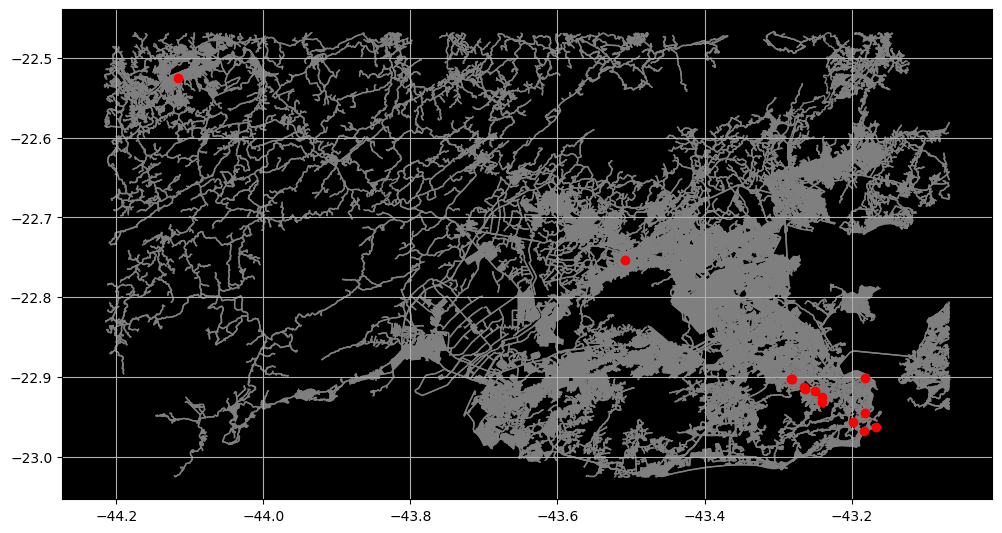

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor('black')
streets.plot(ax=ax, color='gray', zorder=0, linewidth=1)
tickets_nodes.plot(ax=ax, color='red', zorder=5)
plt.grid()

### Calcular matriz de custo

In [70]:
# impute speed on all edges missing data
graph = ox.add_edge_speeds(graph)

# calculate travel time (seconds) for all edges
graph = ox.add_edge_travel_times(graph)

# update streets
streets = ox.graph_to_gdfs(graph, nodes=False)

#### Combinações de origem e destino

In [71]:
import numpy as np
import networkx as nx
from itertools import combinations

# route combinations
unique_tickets = np.unique(tickets_osmid)

route_combinations = list(combinations(unique_tickets, 2))

def cost_route(route):
    paths = nx.shortest_path(graph, route[0], route[1], weight='travel_time')
    return sum(streets.loc[paths,'travel_time'].to_list())/60

#### Construção da matriz

In [72]:
total_travel_time = [cost_route(i) for i in route_combinations]
index = pd.MultiIndex.from_tuples(route_combinations, names=['orig', 'dest'])
df_total_travel_time = pd.Series(total_travel_time, index=index)
df_total_travel_time.drop_duplicates(inplace=True)
df_total_travel_time.head()

orig       dest     
142807318  148823592     8.586667
           149369298     8.995000
           153791875    11.340000
           482158042    19.658333
           496331112    21.756667
dtype: float64

In [73]:
cost_matrix = np.zeros(shape=(len(unique_tickets), len(unique_tickets)))

for i, j in enumerate(unique_tickets):
    for k, l in enumerate(unique_tickets):

        try:
            cost_matrix[i, k] =  df_total_travel_time.loc[(j, l), ]
        except KeyError:
            cost_matrix[i, k] =  0

#### Formatando a matriz

In [74]:
i_lower = np.tril_indices(len(unique_tickets), -1)
cost_matrix[i_lower] = cost_matrix.T[i_lower]
cost_matrix = cost_matrix.astype(int)
cost_matrix = np.insert(cost_matrix, 0, 0, axis=0)
cost_matrix = np.insert(cost_matrix, 0, 0, axis=1)
cost_matrix = cost_matrix.tolist()
cost_matrix

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 8, 8, 11, 19, 21, 24, 147, 51, 20, 28, 21, 26, 18],
 [0, 8, 0, 7, 3, 25, 27, 29, 153, 56, 26, 33, 27, 31, 18],
 [0, 8, 7, 0, 7, 20, 22, 25, 146, 49, 21, 28, 22, 27, 11],
 [0, 11, 3, 7, 0, 25, 27, 30, 151, 55, 26, 34, 27, 32, 16],
 [0, 19, 25, 20, 25, 0, 4, 7, 157, 60, 11, 15, 9, 13, 18],
 [0, 21, 27, 22, 27, 4, 0, 3, 164, 68, 14, 12, 12, 10, 21],
 [0, 24, 29, 25, 30, 7, 3, 0, 163, 67, 17, 11, 15, 9, 24],
 [0, 147, 153, 146, 151, 157, 164, 163, 0, 120, 154, 177, 153, 175, 152],
 [0, 51, 56, 49, 55, 60, 68, 67, 120, 0, 52, 75, 51, 73, 50],
 [0, 20, 26, 21, 26, 11, 14, 17, 154, 52, 0, 24, 3, 22, 17],
 [0, 28, 33, 28, 34, 15, 12, 11, 177, 75, 24, 0, 18, 2, 27],
 [0, 21, 27, 22, 27, 9, 12, 15, 153, 51, 3, 18, 0, 20, 20],
 [0, 26, 31, 27, 32, 13, 10, 9, 175, 73, 22, 2, 20, 0, 27],
 [0, 18, 18, 11, 16, 18, 21, 24, 152, 50, 17, 27, 20, 27, 0]]